In [24]:
!pip install -r requirements.txt

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [25]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import tensorflow as tf
import gzip
from IPython.display import display

from json import loads
from tqdm.notebook import tqdm, trange
from typing import Generator, Iterable, Union, TypeVar
from scipy import sparse
from sklearn.model_selection import train_test_split, KFold


tqdm.pandas()

# Data loading

In [26]:
def parse_json(filename: str, read_max: int = None, attributes: Iterable[str] = None) -> pd.DataFrame:
    """
    Reads the file line by line, parsing each line as json.

    :param filename: The path to the datafile.
    :param read_max: The maximum number of lines to read from the datafile.
    :param attributes: The attributes of each JSON object that should be extracted; other attributes are ignored.
    """
    file = gzip.open(filename, "r")
    data = []
    for index, line in enumerate(tqdm(file)):
        if index == read_max:
            break
        entry = loads(line)
        if attributes is not None:
            entry = {key: entry[key] for key in attributes}
        data.append(entry)
    return pd.DataFrame.from_dict(data)

In [27]:
data_path = "data/"
books = f"{data_path}goodreads_books_comics_graphic.json.gz"
interactions = f"{data_path}goodreads_interactions_comics_graphic.json.gz"
reviews = f"{data_path}goodreads_reviews_comics_graphic.json.gz"

n = 500000

books_df = parse_json(books, n, ("book_id", "title"))
interactions_df = parse_json(interactions, n, ("user_id", "book_id", "rating", "date_updated"))

display(books_df.head(10))
display(interactions_df.head(10))

0it [00:00, ?it/s]

0it [00:00, ?it/s]

,book_id,title
0,25742454,The Switchblade Mamma
1,30128855,Cruelle
2,13571772,Captain America: Winter Soldier (The Ultimate ...
3,35452242,Bounty Hunter 4/3: My Life in Combat from Mari...
4,707611,"Superman Archives, Vol. 2"
5,2250580,"A.I. Revolution, Vol. 1"
6,27036536,"War Stories, Volume 3"
7,27036537,"Crossed, Volume 15"
8,27036538,"Crossed + One Hundred, Volume 2 (Crossed +100 #2)"
9,27036539,"War Stories, Volume 4"


,user_id,book_id,rating,date_updated
0,8842281e1d1347389f2ab93d60773d4d,836610,0,Mon Aug 21 12:11:00 -0700 2017
1,8842281e1d1347389f2ab93d60773d4d,7648967,0,Fri Feb 24 08:59:44 -0800 2017
2,8842281e1d1347389f2ab93d60773d4d,15704307,0,Wed May 20 21:28:57 -0700 2015
3,8842281e1d1347389f2ab93d60773d4d,6902644,0,Sun Jun 01 17:25:23 -0700 2014
4,8842281e1d1347389f2ab93d60773d4d,9844623,0,Sun Sep 02 08:45:08 -0700 2012
5,8842281e1d1347389f2ab93d60773d4d,13163846,0,Tue Jul 24 14:36:13 -0700 2012
6,8842281e1d1347389f2ab93d60773d4d,1137635,0,Fri Mar 26 08:58:33 -0700 2010
7,8842281e1d1347389f2ab93d60773d4d,44735,0,Fri Jun 05 12:28:44 -0700 2009
8,8842281e1d1347389f2ab93d60773d4d,472331,0,Fri Jun 05 12:28:47 -0700 2009
9,8842281e1d1347389f2ab93d60773d4d,24815,5,Thu Apr 17 23:42:49 -0700 2008


In [28]:
# Convert the columns to the correct types
interactions_df["date_updated"] = pd.to_datetime(interactions_df["date_updated"], format="%a %b %d %H:%M:%S %z %Y")
books_df["book_id"] = books_df["book_id"].astype("int64")
interactions_df["book_id"] = interactions_df["book_id"].astype("int64")

# Sort the interactions by user ID and the timestamp
interactions_df = interactions_df.sort_values(by=["user_id", "date_updated"], ascending=[True, True])

# Preprocessing

In [29]:
def preprocess(dataframe: pd.DataFrame, min_support: int = 5) -> pd.DataFrame:
    """
    Removes users with fewer than `min_support` interactions, and duplicate user-item pairs (which do not exist in the
    dataset anyway). Items with very few interactions are not removed, unless they have no interactions at all after
    removing infrequent users.
    """
    print(dataframe.shape[0], "initial rows")
    # Drop reconsumption items
    dataframe = dataframe.drop_duplicates(subset=["user_id", "book_id"])
    # Drop users with less than `min_support` interactions
    items_per_user = dataframe.groupby("user_id", as_index=False)["book_id"].size()
    items_per_user = items_per_user.rename({"size": "items_per_user"}, axis="columns")
    dataframe = pd.merge(dataframe, items_per_user, how="left", on=["user_id"])
    dataframe = dataframe[dataframe["items_per_user"] >= min_support]
    # Report and clean up after the preprocessing
    print(dataframe.shape[0], "rows after preprocessing")
    dataframe.drop(columns=["items_per_user"], inplace=True)
    return dataframe


display(interactions_df.head(10))
print(f"Number of unique users:", interactions_df["user_id"].nunique())
print(f"Number of unique items:", interactions_df["book_id"].nunique())
interactions_df = preprocess(interactions_df, min_support=5)
print(f"Number of unique users:", interactions_df["user_id"].nunique())
print(f"Number of unique items:", interactions_df["book_id"].nunique())
display(interactions_df.head(10))

,user_id,book_id,rating,date_updated
496200,00153d136ac254437511fad5e10e246d,7619292,3,2012-08-30 11:53:39-07:00
496199,00153d136ac254437511fad5e10e246d,29396738,0,2017-08-07 03:40:09-07:00
350064,0018ce6296baeccf95c3502deeff0600,472331,5,2012-08-05 09:26:00-07:00
350062,0018ce6296baeccf95c3502deeff0600,3058907,4,2012-08-05 13:11:48-07:00
350061,0018ce6296baeccf95c3502deeff0600,4280231,4,2012-08-05 13:11:52-07:00
350059,0018ce6296baeccf95c3502deeff0600,11470711,5,2012-08-05 13:14:57-07:00
350058,0018ce6296baeccf95c3502deeff0600,844355,4,2012-08-05 13:19:32-07:00
350057,0018ce6296baeccf95c3502deeff0600,1568491,4,2012-08-05 13:19:39-07:00
350056,0018ce6296baeccf95c3502deeff0600,23754,4,2012-08-09 03:53:26-07:00
350063,0018ce6296baeccf95c3502deeff0600,13480845,5,2012-08-15 04:26:40-07:00


Number of unique users: 18246
Number of unique items: 53635
500000 initial rows
482272 rows after preprocessing
Number of unique users: 8931
Number of unique items: 53210


,user_id,book_id,rating,date_updated
2,0018ce6296baeccf95c3502deeff0600,472331,5,2012-08-05 09:26:00-07:00
3,0018ce6296baeccf95c3502deeff0600,3058907,4,2012-08-05 13:11:48-07:00
4,0018ce6296baeccf95c3502deeff0600,4280231,4,2012-08-05 13:11:52-07:00
5,0018ce6296baeccf95c3502deeff0600,11470711,5,2012-08-05 13:14:57-07:00
6,0018ce6296baeccf95c3502deeff0600,844355,4,2012-08-05 13:19:32-07:00
7,0018ce6296baeccf95c3502deeff0600,1568491,4,2012-08-05 13:19:39-07:00
8,0018ce6296baeccf95c3502deeff0600,23754,4,2012-08-09 03:53:26-07:00
9,0018ce6296baeccf95c3502deeff0600,13480845,5,2012-08-15 04:26:40-07:00
10,0018ce6296baeccf95c3502deeff0600,3887304,5,2012-10-10 03:59:19-07:00
11,0018ce6296baeccf95c3502deeff0600,12079555,3,2015-02-07 04:25:49-08:00


In [30]:
def apply_consecutive_mapping(dataframe: pd.DataFrame, column: str, new_column: str, *additional: pd.DataFrame) -> None:
    """
    Generates a consecutive ID column for the values of an existing column. Also adds this column to additional data
    frames with the exact same mapping of old ID to new (consecutive) ID.
    """
    ids = {}

    def map_to_consecutive_ids(uuid: Union[int, np.int64]) -> int:
        """
        To be used with `pd.Dataframe.apply()` or `pd.Dataframe.progress_apply()`; returns a unique ID per distinct
        value.
        """
        if uuid not in ids:
            ids[uuid] = len(ids)
        return ids[uuid]

    dataframe[new_column] = dataframe[column].progress_apply(map_to_consecutive_ids)
    for frame in additional:
        frame[new_column] = frame[column].progress_apply(lambda old_id: ids.get(old_id, -1))


apply_consecutive_mapping(interactions_df, "user_id", "user_id_int")
apply_consecutive_mapping(interactions_df, "book_id", "book_id_int", books_df)

interactions_df = interactions_df[["user_id_int", "book_id_int", "date_updated", "rating"]]
interactions_df = interactions_df.rename(
    columns={"user_id_int": "user_id", "book_id_int": "item_id", "date_updated": "datetime"})

display(books_df.head(10))
display(interactions_df.head(10))

  0%|          | 0/482272 [00:00<?, ?it/s]

  0%|          | 0/482272 [00:00<?, ?it/s]

  0%|          | 0/89411 [00:00<?, ?it/s]

,book_id,title,book_id_int
0,25742454,The Switchblade Mamma,-1
1,30128855,Cruelle,15002
2,13571772,Captain America: Winter Soldier (The Ultimate ...,43185
3,35452242,Bounty Hunter 4/3: My Life in Combat from Mari...,-1
4,707611,"Superman Archives, Vol. 2",-1
5,2250580,"A.I. Revolution, Vol. 1",11921
6,27036536,"War Stories, Volume 3",46912
7,27036537,"Crossed, Volume 15",46927
8,27036538,"Crossed + One Hundred, Volume 2 (Crossed +100 #2)",46931
9,27036539,"War Stories, Volume 4",13789


,user_id,item_id,datetime,rating
2,0,0,2012-08-05 09:26:00-07:00,5
3,0,1,2012-08-05 13:11:48-07:00,4
4,0,2,2012-08-05 13:11:52-07:00,4
5,0,3,2012-08-05 13:14:57-07:00,5
6,0,4,2012-08-05 13:19:32-07:00,4
7,0,5,2012-08-05 13:19:39-07:00,4
8,0,6,2012-08-09 03:53:26-07:00,4
9,0,7,2012-08-15 04:26:40-07:00,5
10,0,8,2012-10-10 03:59:19-07:00,5
11,0,9,2015-02-07 04:25:49-08:00,3


In [31]:
DataType = TypeVar("DataType", pd.DataFrame, sparse.csr_matrix)


def generate_random_split(data: DataType, seed: int = None) -> tuple:
    return train_test_split(data, test_size=0.2, random_state=seed)


def create_sparse_matrix(dataframe: pd.DataFrame, shape: tuple = None) -> sparse.csr_matrix:
    return sparse.csr_matrix((dataframe["rating"], (dataframe["user_id"], dataframe["item_id"])), shape=shape,
                             dtype=np.int8)


def convert_sparse_matrix_to_sparse_tensor(X) -> tf.SparseTensor:
    coo = X.tocoo()
    indices = np.mat([coo.row, coo.col]).transpose()
    return tf.SparseTensor(indices, np.float32(coo.data), coo.shape)

In [32]:
shape = (interactions_df["user_id"].max() + 1, interactions_df["item_id"].max() + 1)
interaction_matrix = create_sparse_matrix(interactions_df, shape)
normalized_matrix = interaction_matrix
normalized_matrix.data = (interaction_matrix.data / 5.0)

# Restricted Boltzmann Machine

In [33]:
hiddenUnits = 20
visibleUnits = shape[1]

We then move on to creating the visible and hidden layer units and setting their activation functions. In this case, we
will be using the <code>tf.sigmoid</code> and <code>tf.relu</code> functions as nonlinear activations since it is
commonly used in RBM's.

In [34]:
# Input processing: Defining a function to return only the generated hidden states

def hidden_layer(v0_state, W, hb):
    # Probabilities of the hidden units
    h0_prob = tf.nn.sigmoid(tf.matmul(v0_state, W) + hb)

    #Sample h  given x
    return tf.nn.relu(tf.sign(h0_prob - tf.random.uniform(tf.shape(h0_prob))))


def reconstructed_output(h0_state, W, vb):
    v1_prob = tf.nn.sigmoid(tf.matmul(h0_state, tf.transpose(W)) + vb)
    return tf.nn.relu(tf.sign(v1_prob - tf.random.uniform(tf.shape(v1_prob))))


def gibbs_sampling(v0_state: tf.Tensor, weights: tf.Variable, bias_visible: tf.Variable, bias_hidden: tf.Variable,
                   nr_iterations: int = 1) -> tuple:
    """
    Performs gibbs sampling starting with the given input vector.
    :return: A tuple consisting of (in order):
        - The hidden layer `h0_state`, sampled from the given data vector `v0_state`.
        - The final visible layer `vk_state`.
        - The final hidden layer `hk_state`.
    """
    h0_state = hidden_layer(v0_state, weights, hb)
    vk_state = v0_state
    hk_state = h0_state
    for _ in range(nr_iterations):
        vk_state = reconstructed_output(hk_state, weights, bias_visible)
        hk_state = hidden_layer(vk_state, weights, bias_hidden)
    return h0_state, vk_state, hk_state

In [35]:
def error(v0_state, v1_state):
    """
    Returns the sum of the squared reconstruction errors. This error is computed per batch, and should be accumulated
    per epoch. At the end of the epoch the total RMSE can then be computed from that sum.
    """
    return tf.reduce_sum(tf.reduce_mean(tf.square(v0_state - v1_state), 1))

# Training the RBM

In [36]:
# Training hyperparameters
epochs = 5
batch_size = 500
K = 1
alpha = 0.1  # Learning rate

In [37]:
def train_rbm(train: tf.data.Dataset, validation: tf.data.Dataset, W: tf.Variable, vb: tf.Variable, hb: tf.Variable) -> tuple:
    train_errors = []
    validation_errors = []
    weights = []

    print(len(train))

    for epoch in trange(epochs, leave=False):
        train_errors.append(0)
        train_iter = iter(train)
        for _ in trange(len(train), leave=False):

            v0_state = tf.sparse.to_dense(next(train_iter))
            h0_state, vk_state, hk_state = gibbs_sampling(v0_state, W, vb, hb, K)

            temp_0 = tf.matmul(tf.transpose(v0_state), tf.squeeze(h0_state))
            temp_k = tf.matmul(tf.transpose(vk_state), tf.squeeze(hk_state))
            delta_W = (temp_0 - temp_k) / v0_state.shape[0]

            W = W + alpha * delta_W
            vb = vb + alpha * tf.reduce_mean(v0_state - vk_state, 0)
            hb = hb + alpha * tf.reduce_mean(tf.squeeze(h0_state - hk_state), 0)

            train_errors[-1] += error(v0_state, vk_state)

        validation_errors.append(0)
        validation_iter = iter(validation)
        for _ in trange(len(validation), leave=False):
            v0_state = tf.sparse.to_dense(next(validation_iter))
            _, vk_state, _ = gibbs_sampling(v0_state, W, vb, hb, 1)
            validation_errors[-1] += error(v0_state, vk_state)

        train_errors[-1] = (train_errors[-1] / len(train)) ** 0.5
        validation_errors[-1] = (validation_errors[-1] / len(validation)) ** 0.5
        weights.append(W)
        # print(f"Epoch {epoch + 1:3}:  {train_errors[-1]:10.5}  ;  {validation_errors[-1]:10.5}")

    return W, vb, hb, train_errors, validation_errors

In [38]:
def plot_errors(train_errors: list, validation_errors: list, file_name: str = None) -> None:
    plt.plot(range(1, epochs + 1), train_errors, label="Train")
    plt.plot(range(1, epochs + 1), validation_errors, label="Validation")
    plt.ylabel("Error")
    plt.xlabel("Epoch")
    plt.legend()
    if file_name is not None:
        plt.savefig("rmse.png")
    plt.show()

In [39]:
def split_k_folds(data: sparse.csr_matrix, nr_folds: int = 5) -> Generator[tuple, None, None]:
    """
    Generates K train-test splits for K-fold cross validation.
    """
    kf = KFold(n_splits=nr_folds)
    yield from kf.split(data)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   3:      10.603  ;      9.9609


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   4:      9.5451  ;      9.0391


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   5:      8.7069  ;      8.3008
12


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   1:      13.813  ;      12.653


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   2:      11.963  ;      11.124


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   3:      10.595  ;      9.9559


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   4:      9.5401  ;      9.0309


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   5:      8.7041  ;      8.2967
12


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   1:      13.823  ;      12.652


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   2:      11.963  ;       11.11


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   3:      10.592  ;      9.9488


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   4:       9.542  ;      9.0456


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   5:      8.6993  ;      8.2956


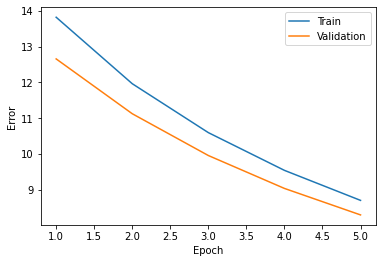

12


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   1:      13.819  ;      12.646


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   2:      11.963  ;      11.135


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   3:      10.593  ;      9.9463


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   4:      9.5358  ;      9.0329


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   5:      8.6996  ;      8.3159
12


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   1:      13.814  ;       12.64


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   2:      11.956  ;      11.106


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   3:      10.595  ;      9.9288


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   4:      9.5394  ;      9.0129


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   5:      8.7013  ;      8.2784
12


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   1:      13.818  ;      12.648


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   2:      11.963  ;      11.125


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   3:      10.595  ;      9.9527


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   4:      9.5332  ;      9.0322


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   5:      8.7036  ;      8.2957
12


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   1:      13.828  ;      12.667


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   2:      11.964  ;      11.127


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   3:      10.597  ;      9.9504


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   4:      9.5402  ;      9.0374


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   5:      8.7053  ;      8.3025
12


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   1:       13.82  ;      12.657


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   2:      11.962  ;      11.134


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   3:      10.598  ;       9.961


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   4:       9.544  ;      9.0252


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   5:      8.7088  ;      8.3008


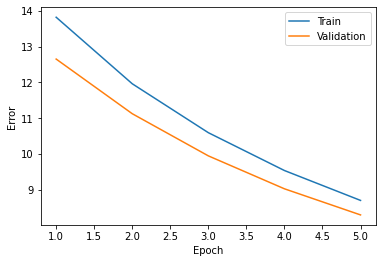

12


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   1:      13.824  ;      12.671


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   2:      11.965  ;      11.129


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   3:      10.599  ;      9.9645


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   4:      9.5419  ;      9.0478


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   5:      8.7078  ;       8.308
12


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   1:      13.818  ;      12.655


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   2:      11.958  ;      11.126


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   3:      10.593  ;      9.9647


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   4:      9.5332  ;      9.0244


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   5:      8.7022  ;      8.3004
12


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   1:      13.824  ;       12.66


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   2:      11.967  ;       11.13


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   3:      10.606  ;      9.9499


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   4:      9.5438  ;      9.0344


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   5:      8.7081  ;      8.2874
12


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   1:       13.81  ;      12.665


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   2:      11.958  ;      11.134


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   3:      10.596  ;      9.9624


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   4:      9.5389  ;      9.0255


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   5:       8.704  ;      8.2888
12


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   1:      13.826  ;      12.657


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   2:       11.97  ;      11.113


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   3:      10.603  ;      9.9468


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   4:      9.5389  ;      9.0237


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   5:      8.7043  ;      8.2856


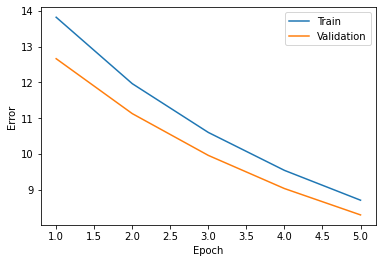

12


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   1:      13.815  ;      12.638


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   2:      11.958  ;      11.132


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   3:      10.594  ;       9.963


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   4:      9.5298  ;      9.0356


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   5:      8.6987  ;      8.3177
12


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   1:      13.807  ;      12.633


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   2:      11.959  ;       11.11


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   3:      10.592  ;      9.9429


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   4:      9.5374  ;      9.0243


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   5:      8.6972  ;       8.288
12


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   1:      13.811  ;       12.65


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   2:      11.962  ;      11.112


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   3:      10.601  ;       9.939


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   4:      9.5414  ;      9.0421


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   5:      8.7047  ;       8.299
12


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   1:      13.809  ;      12.665


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   2:       11.96  ;      11.142


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   3:      10.598  ;      9.9583


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   4:       9.537  ;      9.0323


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   5:      8.7055  ;      8.3077
12


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   1:       13.82  ;      12.658


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   2:      11.966  ;      11.132


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   3:      10.605  ;       9.966


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   4:      9.5395  ;      9.0343


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   5:      8.7056  ;      8.3015


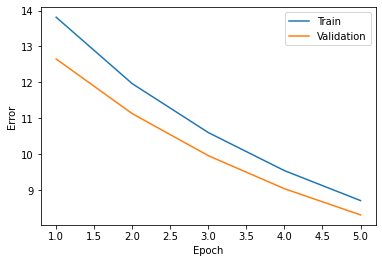

12


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   1:      13.817  ;      12.674


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   2:      11.963  ;      11.138


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   3:      10.598  ;      9.9622


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   4:      9.5402  ;      9.0449


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   5:      8.7049  ;      8.3078
12


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   1:      13.816  ;      12.667


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   2:      11.963  ;      11.147


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   3:      10.598  ;       9.974


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   4:      9.5418  ;      9.0461


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   5:      8.7091  ;      8.3051
12


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   1:      13.829  ;      12.647


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   2:      11.973  ;      11.121


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   3:      10.604  ;      9.9596


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   4:      9.5398  ;       9.047


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   5:      8.7071  ;      8.3013
12


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   1:      13.821  ;      12.655


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   2:      11.966  ;      11.112


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   3:      10.604  ;      9.9527


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   4:      9.5456  ;      9.0385


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   5:      8.7103  ;      8.2962
12


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   1:       13.82  ;      12.648


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   2:      11.965  ;      11.121


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   3:      10.598  ;      9.9591


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   4:      9.5409  ;      9.0366


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   5:      8.7071  ;      8.2949


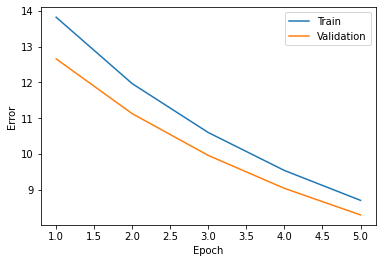

12


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   1:      13.831  ;      12.667


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   2:      11.964  ;      11.134


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   3:      10.604  ;      9.9517


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   4:      9.5489  ;      9.0428


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   5:      8.7121  ;       8.295
12


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   1:      13.815  ;      12.646


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   2:      11.962  ;      11.128


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   3:      10.588  ;      9.9536


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   4:      9.5379  ;      9.0492


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   5:      8.6952  ;      8.3142
12


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   1:      13.813  ;      12.679


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   2:       11.96  ;      11.144


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   3:      10.602  ;      9.9685


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   4:      9.5404  ;      9.0353


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   5:      8.7118  ;      8.2991
12


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   1:      13.819  ;      12.667


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   2:      11.971  ;      11.133


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   3:      10.596  ;       9.959


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   4:       9.541  ;       9.048


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   5:      8.7098  ;       8.306
12


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   1:      13.836  ;      12.663


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   2:      11.982  ;      11.122


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   3:      10.608  ;      9.9534


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   4:      9.5486  ;      9.0339


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   5:      8.7123  ;      8.3004


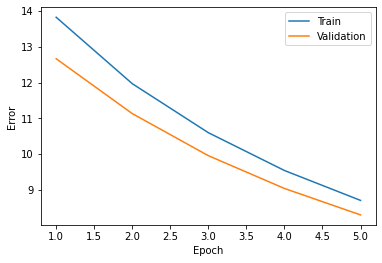

12


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   1:      13.813  ;       12.66


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   2:      11.962  ;      11.124


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   3:      10.594  ;      9.9656


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   4:      9.5348  ;      9.0375


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   5:       8.698  ;       8.309
12


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   1:      13.819  ;      12.645


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   2:      11.963  ;      11.121


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   3:      10.596  ;      9.9429


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   4:      9.5416  ;      9.0302


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   5:      8.7046  ;      8.2901
12


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   1:      13.819  ;      12.661


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   2:      11.958  ;      11.142


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch   3:      10.593  ;      9.9671


  0%|          | 0/12 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [51]:
for seed in range(1, 6):
    train, test = generate_random_split(normalized_matrix, seed=seed)

    mean_train_errors = [0] * epochs
    mean_validation_errors = [0] * epochs

    for train_indices, validation_indices in split_k_folds(train):
        tensor_train = convert_sparse_matrix_to_sparse_tensor(train[train_indices])
        tensor_validation = convert_sparse_matrix_to_sparse_tensor(train[validation_indices])

        train_ds = tf.data.Dataset.from_tensor_slices(tensor_train).batch(batch_size)
        validation_ds = tf.data.Dataset.from_tensor_slices(tensor_validation).batch(batch_size)

        vb = tf.Variable(tf.zeros([visibleUnits]), tf.float32)
        hb = tf.Variable(tf.zeros([hiddenUnits]), tf.float32)
        W = tf.Variable(tf.zeros([visibleUnits, hiddenUnits]), tf.float32)

        W, vb, hb, train_errors, validation_errors = train_rbm(train_ds, validation_ds, W, vb, hb)

        for epoch in range(epochs):
            mean_train_errors[epoch] += train_errors[epoch] / 5
            mean_validation_errors[epoch] += validation_errors[epoch] / 5

    plot_errors(mean_train_errors, mean_validation_errors)